## 音乐网站用户流失预测数据探索
by Johnkle  
2019/08/09

#### 大体思路 
把该问题转化为一个CVR问题。  
构造特征，把协同过滤的推荐度作为特征。  
1.user_based协同过滤需要user-user相似度矩阵和user-item行为矩阵，user-user有两种相似度（user信息和eventForUser分别计算出两种相似度），从而根据user_based协同过滤构造两个特征userReco。  
2.item_based协同过滤需要item-item相似度矩阵和user-item行为矩阵，item-item有两种相似度（item信息和userForEvent分别计算出两种相似度），从而根据item_based协同过滤构造两个特征itemReco。  
3.构造用户活跃度userPop特征，计算每个user评分过的item的数量，user评分过的item数量越多，用户越活跃。  
4.构造item热度itemPop特征，计算每个item被评分过的user的数量，item被评分过的user数量越多，item热度越高。  
把以上构造出的6个特征加入到train数据集中，形成新的数据集，作为分类模型的输入。  

基于以上想法，本项目的songs和members数据集被用来计算user-user相似度和item-item相似度，从而构造相应的特征。  

冷启动问题  
当一个新user出现，可以根据user信息得到userReco  
当一个新item出现，可以根据item信息得到itemReco

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

### 1. train数据探索

In [2]:
dpath = "../Data/"
train = pd.read_csv(dpath+"train.csv")
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [4]:
#用户的数量
len(train["msno"].unique())

30755

In [5]:
#歌曲的数量
len(train["song_id"].unique())

359966

#### 样本分布
样本分布均衡，不需要进行下采样

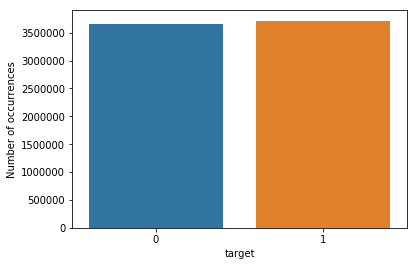

In [6]:
sns.countplot(train.target);
plt.xlabel('target');
plt.ylabel('Number of occurrences');

查看每个特征的缺省值数目，缺省值用众数填充
(这里缺省值都是离散型特征)

In [7]:
train.apply(lambda x:sum(x.isnull()))

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

#### 特征分布
对于出现频次比较高的特征做单独处理，出现频次比较低的特征归类为其他

#### source_system_tab分布

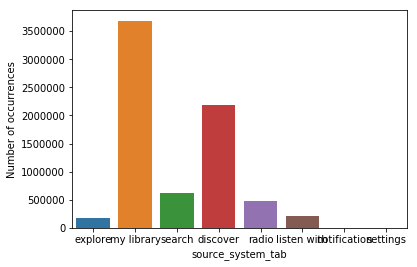

In [8]:
sns.countplot(train.source_system_tab);
plt.xlabel("source_system_tab");
plt.ylabel("Number of occurrences");

source_system_tab不同取值出现的频次

In [9]:
train["source_system_tab"].value_counts()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64

#### source_screen_name分布
用户在哪听到对应的音乐(本地/在线/搜寻...)

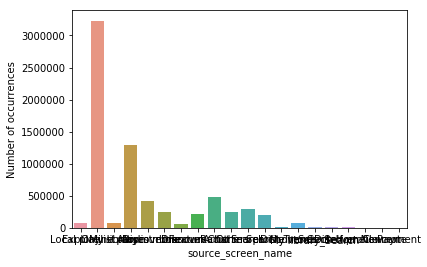

In [10]:
sns.countplot(train.source_screen_name);
plt.xlabel("source_screen_name");
plt.ylabel("Number of occurrences");

source_screen_name不同取值出现频次，频次低于100000次合并为其他

In [11]:
train["source_screen_name"].value_counts()

Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: source_screen_name, dtype: int64

#### source_type分布

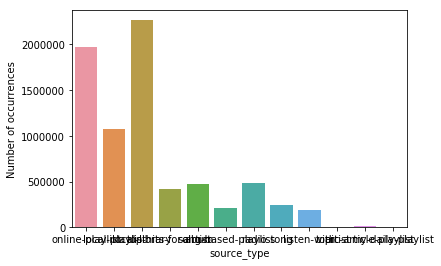

In [12]:
sns.countplot(train.source_type);
plt.xlabel("source_type");
plt.ylabel("Number of occurrences");

source_type不同取值出现频次，频次低于200000次合并为其他

In [13]:
train["source_type"].value_counts()

local-library             2261399
online-playlist           1967924
local-playlist            1079503
radio                      483109
album                      477344
top-hits-for-artist        423614
song                       244722
song-based-playlist        210527
listen-with                192842
topic-article-playlist      11194
artist                       3038
my-daily-playlist             663
Name: source_type, dtype: int64

### 2. songs数据探索

In [14]:
songs = pd.read_csv(dpath + "songs.csv")
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [15]:
songs.shape

(2296320, 7)

In [16]:
len(songs["song_id"].unique())

2296320

#### songs特征分布

查看songs每个特征缺省值的数目

composer和lyricist缺失值过多，舍弃，artist_name也舍弃？

In [17]:
songs.apply(lambda x:sum(x.isnull()))

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

song_length是连续型特征，如何做分桶bucket？

#### genre_ids分布  
把出现频次较低的genre_ids归类为其他，低于哪个阈值可以认定为频次低，代码如何实现此操作？    

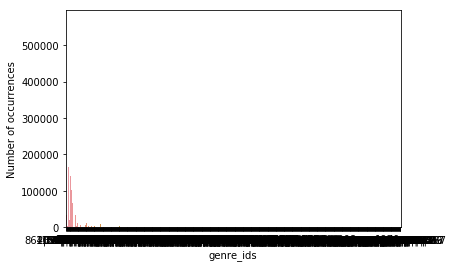

In [18]:
sns.countplot(songs.genre_ids);
plt.xlabel("genre_ids");
plt.ylabel("Number of occurrences");

In [19]:
len(songs["genre_ids"].unique())

1046

In [20]:
songs["genre_ids"].value_counts()[:40]

465                567911
958                176349
2022               168870
1609               166457
2122               139938
1259               101485
921                 67578
1152                48730
359                 43601
786                 42999
726                 34969
139                 34876
1011                34013
940                 33490
1572|275            24338
1955                20980
691                 19472
139|125|109         17613
873                 17542
437                 17212
947                 17106
388                 16776
458                 15438
444                 14859
1616                14188
242                 13756
451                 13283
880                 13059
423                 11814
829                 11759
2130                11053
1138                10770
1180                10702
1616|2058            9283
893                  7527
1152|947             7355
864|857|850|843      6842
409                  6519
2072        

artist_name,composer,lyricist都是人名，如何处理？hash？直接丢掉？

#### language分布

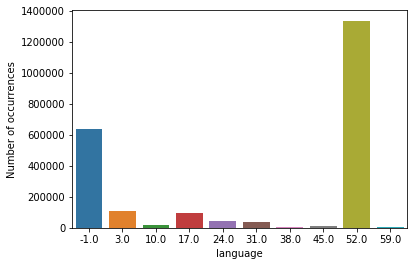

In [21]:
sns.countplot(songs.language);
plt.xlabel("language");
plt.ylabel("Number of occurrences");

In [22]:
songs["language"].value_counts()

 52.0    1336694
-1.0      639467
 3.0      106295
 17.0      92518
 24.0      41744
 31.0      39201
 10.0      15482
 45.0      14435
 59.0       8098
 38.0       2385
Name: language, dtype: int64

### 3. members数据探索

In [23]:
members = pd.read_csv(dpath + "members.csv")
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [24]:
members.shape

(34403, 7)

In [25]:
len(members["msno"].unique())

34403

#### members特征分布

查看members缺失值

In [26]:
members.apply(lambda x:sum(x.isnull()))

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

#### city分布

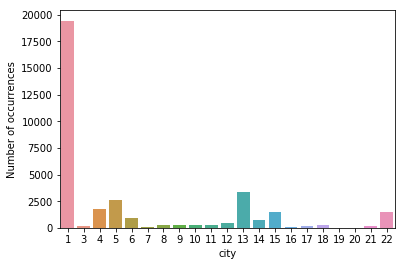

In [27]:
sns.countplot(members.city);
plt.xlabel("city");
plt.ylabel("Number of occurrences");

In [28]:
members["city"].value_counts()

1     19445
13     3395
5      2634
4      1732
15     1525
22     1467
6       913
14      708
12      491
9       309
8       289
11      285
18      259
10      216
21      213
3       204
17      152
7        93
16       35
20       27
19       11
Name: city, dtype: int64

#### bd分布  
bd值默认为0的较多，该如何操作，用中位数填充？还是归类为其他？   
如何查看离群点，离群点如何剔除？

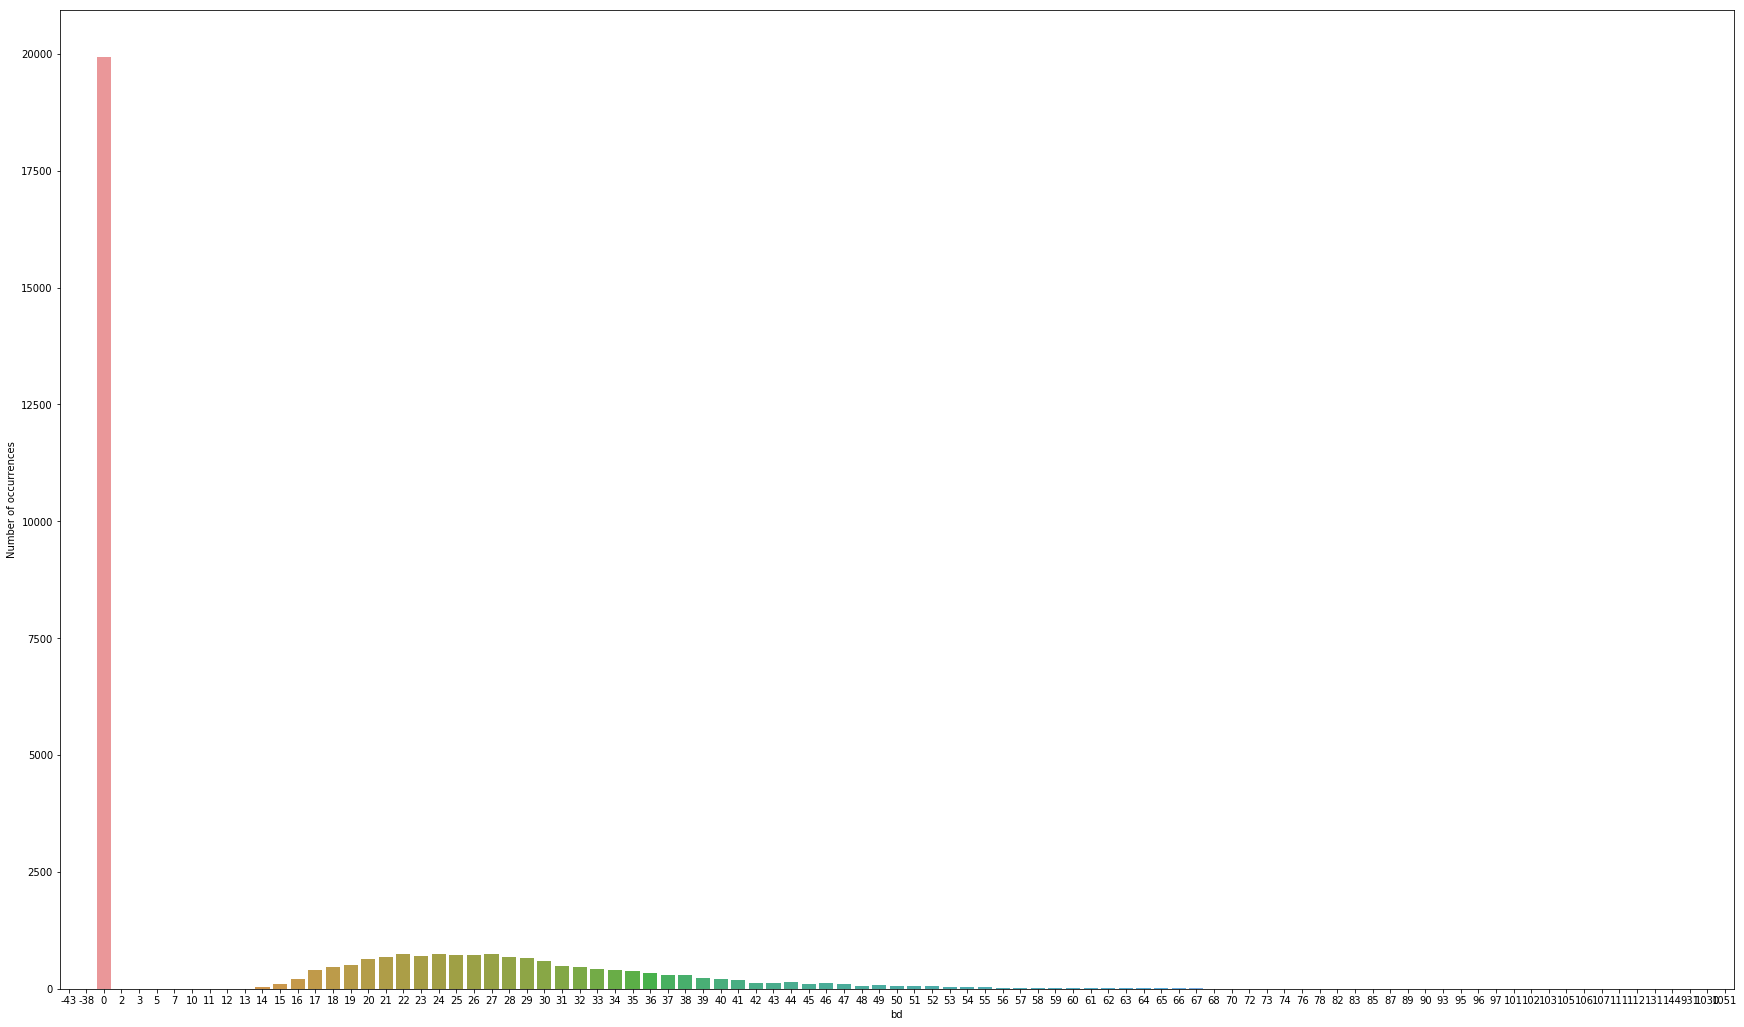

In [38]:
plt.figure(figsize=(30, 18))
sns.countplot(members.bd);
plt.xlabel("bd");
plt.ylabel("Number of occurrences");

In [30]:
members["bd"].value_counts()

 0       19932
 22        751
 27        750
 24        740
 26        719
 25        716
 23        712
 28        688
 21        685
 29        661
 20        631
 30        602
 19        507
 31        491
 32        466
 18        466
 33        416
 34        404
 17        398
 35        380
 36        341
 37        300
 38        294
 39        226
 16        215
 40        204
 41        194
 44        138
 42        131
 43        121
         ...  
 102         2
 131         1
 78          1
 85          1
 3           1
 2           1
 1051        1
 97          1
 144         1
 93          1
 96          1
-43          1
 82          1
 931         1
 106         1
 76          1
 87          1
 101         1
 90          1
 70          1
 1030        1
 7           1
 12          1
 103         1
-38          1
 89          1
 107         1
 10          1
 11          1
 95          1
Name: bd, Length: 95, dtype: int64

#### gender分布  
gender缺失值较多，且有值的样本分布均衡，是否要舍弃该特征？还是把缺失值单独编码，分为有缺失和无缺失？

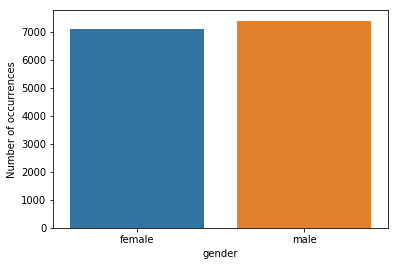

In [31]:
sns.countplot(members.gender);
plt.xlabel("gender");
plt.ylabel("Number of occurrences");

#### registered_via分布

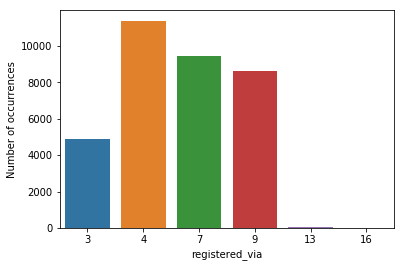

In [32]:
sns.countplot(members.registered_via);
plt.xlabel("registered_via");
plt.ylabel("Number of occurrences");

In [33]:
members["registered_via"].value_counts()

4     11392
7      9433
9      8628
3      4879
13       70
16        1
Name: registered_via, dtype: int64

registration_init_time和expiration_date连续型时间特征如何处理？  
截掉month/day，只保留year,然后one-hot，或者直接当作连续值分桶？  

缺失值处理  
from sklearn.preprocessing import Imputer  
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [34]:
from sklearn.preprocessing import Imputer